In [1]:
import pandas as pd
# from retentioneering import datasets
from typing import Literal, Union, List, Optional, Iterable, get_args, Dict, Tuple
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

from abc import ABC, abstractmethod
import warnings

import datetime
import itertools

In [2]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

for path in sys.path:
    print(path)

D:\pythonProg\Python\Python312\python312.zip
D:\pythonProg\Python\Python312\DLLs
D:\pythonProg\Python\Python312\Lib
D:\pythonProg\Python\Python312
d:\diplom\.venv

d:\diplom\.venv\Lib\site-packages
d:\diplom\.venv\Lib\site-packages\win32
d:\diplom\.venv\Lib\site-packages\win32\lib
d:\diplom\.venv\Lib\site-packages\Pythonwin
d:\diplom\product\insight_pulse


In [3]:
from eventframing.eventframe import EventFrame
from eventframing.cols_schema import EventFrameColsSchema
from eventframing.event_type import EventType

from data_preprocessing.preprocessors_lib.add_start_end_events import AddStartEndEventsPreprocessor
from data_preprocessing.preprocessors_lib.split_sessions import SplitSessionsPreprocessor

from utils.time_units import TimeUnits
from utils.time_unit_period import TimeUnitPeriod

## Data Generation

In [4]:
def generate_user_events_data(num_users=1000, num_events=10, num_cities=10, num_os=2, num_rows=5000, seed=42):
    """
    Функция для генерации данных о событиях пользователей.
    """
    # Устанавливаем seed для генератора случайных чисел
    np.random.seed(seed)

    # Создаем список пользователей
    users = ['user' + str(i) for i in range(1, num_users+1)]

    # Создаем список событий
    events = ['event' + str(i) for i in range(1, num_events+1)]

    # Создаем список дат
    dates = [datetime.datetime.now() - datetime.timedelta(days=x) for x in range(180)]

    # Создаем список городов
    cities = ['city' + str(i) for i in range(1, num_cities+1)]

    # Создаем список операционных систем
    os = ['iOS', 'Android']

    statuses = ['status' + str(i) for i in range(1, num_os+1)]

    # Создаем DataFrame
    df = pd.DataFrame({
        'user_id': np.random.choice(users, num_rows),
        'event': np.random.choice(events, num_rows),
        'event_datetime': np.random.choice(dates, num_rows),
        'city': np.random.choice(cities, num_rows),
        'operation_system': np.random.choice(os, num_rows),
        'status': np.random.choice(statuses, num_rows)
    })

    return df

In [5]:
data = generate_user_events_data(num_rows=500, num_users=5000)
cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
ef = EventFrame(data, cols_schema)
ef.to_dataframe().head()

EventFrameColsSchema(event_id=None, event_type=None, event_index=None, event_name=event, event_timestamp=event_datetime, user_id=user_id, session_id=None, cohort_group=None, custom_cols=[])


,user_id,event,event_datetime,city,operation_system,status,event_id,event_type,event_type_index
375,user1013,event9,2025-01-08 15:16:01.929281,city9,iOS,status1,375,raw,2
417,user1016,event1,2024-12-02 15:16:01.929281,city5,iOS,status1,417,raw,2
213,user1017,event7,2025-03-01 15:16:01.929281,city10,Android,status2,213,raw,2
72,user1017,event3,2025-03-19 15:16:01.929281,city8,Android,status2,72,raw,2
57,user1022,event9,2025-01-25 15:16:01.929281,city5,iOS,status2,57,raw,2


## Implementation

In [58]:
class UserScenarios:
    _path_end_event_name = 'ENDED'

    def __init__(self, ef: EventFrame):
        self.ef = ef
        self.cols_schema = ef.cols_schema
    
    def _get_data_and_schema(self, data: Optional[Union[EventFrame, pd.DataFrame]] = None) -> Tuple[pd.DataFrame, EventFrameColsSchema]:
        if data is None:
            data = self.ef.to_dataframe().copy()
            cols_schema = self.cols_schema
        else:
            cols_schema = data.cols_schema
            data = data.to_dataframe().copy()
        return data, cols_schema
    
    def fit(self, data: Optional[EventFrame] = None,
             max_steps: int = 10, inside_session: bool = True, interchangeable_events: List[List[str]] = None,
             threshold: float = 0.00, steps_as_index: bool = False) -> pd.DataFrame:
        data, cols_schema = self._get_data_and_schema(data=data)
        if inside_session and cols_schema.session_id is None:
            raise ValueError('EventFrame does not have session_id column.')

        user_col = cols_schema.user_id
        event_col = cols_schema._event_name
        session_col = cols_schema.session_id
        dt_col = cols_schema.event_timestamp

        weight_col = session_col if inside_session else user_col

        # Add column with number of step in session or the whole path
        data = data.sort_values(by=[user_col, dt_col])
        data['step'] = data.groupby(weight_col)[dt_col].cumcount() + 1
        data = data[data['step'] <= max_steps]

        # Add path terminating event if user has less steps than max_steps
        data = data.pivot_table(index=weight_col, columns='step', values=event_col, aggfunc=lambda x: x)\
            .fillna(self._path_end_event_name).reset_index()
        
        step_cols = list(data.drop(columns=[weight_col]).columns)
        if interchangeable_events is not None:
            replacement_dict = {}
            for group in interchangeable_events:
                group_name = '/'.join(group)
                for event in group:
                    replacement_dict[event] = group_name

            for col in step_cols:
                data[col] = data[col].replace(replacement_dict)

        data = data.groupby(step_cols)[weight_col].nunique()\
            .reset_index()\
            .rename(columns={weight_col: f'unique_{weight_col}'})\
            .sort_values(f'unique_{weight_col}', ascending=False)
        
        data[f'persent_of_{weight_col}'] = data[f'unique_{weight_col}'].divide(data[f'unique_{weight_col}'].sum()).mul(100).round(2)
        data = data[data[f'persent_of_{weight_col}'] >= threshold * 100]
        if steps_as_index:
            data = data.set_index(step_cols)

        return data


In [60]:
data = generate_user_events_data(num_rows=50000, num_users=50)
cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
ef = EventFrame(data, cols_schema)
# user_col = 'user_id'
# dt_col = 'event_datetime'

# data = data.sort_values(by=[user_col, dt_col])
# data.groupby('user_id')['event_datetime'].cumcount() + 1

us = UserScenarios(ef)
m = us.fit(max_steps=5, inside_session=False, interchangeable_events = [['event1', 'event2'], ['event3', 'event4']], steps_as_index=True)

m


EventFrameColsSchema(event_id=None, event_type=None, event_index=None, event_name=event, event_timestamp=event_datetime, user_id=user_id, session_id=None, cohort_group=None, custom_cols=[])


unique_user_id  \
1             2             3             4             5                               
event1/event2 event10       event10       event6        event3/event4               1   
              event3/event4 event1/event2 event10       event9                      1   
                            event3/event4 event3/event4 event3/event4               1   
                                          event6        event8                      1   
                            event9        event10       event6                      1   
              event5        event1/event2 event7        event10                     1   
                            event6        event10       event3/event4               1   
                                                        event8                      1   
              event6        event3/event4 event8        event6                      1   
                            event7        event1/event2 event5                      1   
event10       event3/event4 event3/event4 event9        event6                      1   
                            event9        event9        event8                      1   
              event8        event3/event4 event1/event2 event5                      1   
                                          event10       event5                      1   
              event9        event3/event4 event10       event8                      1   
                                          event8        event6                      1   
                            event6        event1/event2 event6                      1   
event3/event4 event3/event4 event1/event2 event1/event2 event6                      1   
                            event3/event4 event1/event2 event7                      1   
                            event6        event3/event4 event9                      1   
                            event7        event7        event1/event2               1   
              event5        event1/event2 event8        event9                      1   
              event6        event3/event4 event7        event8                      1   
              event7        event7        event1/event2 event6                      1   
              event8        event10       event7        event3/event4               1   
              event9        event7        event5        event3/event4               1   
                                          event9        event5                      1   
event5        event1/event2 event5        event10       event6                      1   
                                          event8        event9                      1   
              event5        event5        event3/event4 event9                      1   
                            event6        event3/event4 event8                      1   
                            event7        event8        event9                      1   
              event9        event6        event6        event7                      1   
event6        event3/event4 event6        event6        event1/event2               1   
              event5        event3/event4 event3/event4 event7                      1   
              event8        event3/event4 event3/event4 event3/event4               1   
                            event7        event10       event6                      1   
event7        event1/event2 event10       event8        event3/event4               1   
                            event3/event4 event1/event2 event9                      1   
event8        event1/event2 event1/event2 event5        event1/event2               1   
              event10       event3/event4 event3/event4 event8                      1   
              event3/event4 event5        event10       event6                      1   
              event7        event1/event2 event3/event4 event8                      1   
                                          event8        event5    

In [65]:
m

unique_user_id  \
1             2             3             4             5                               
event1/event2 event10       event10       event6        event3/event4               1   
              event3/event4 event1/event2 event10       event9                      1   
                            event3/event4 event3/event4 event3/event4               1   
                                          event6        event8                      1   
                            event9        event10       event6                      1   
              event5        event1/event2 event7        event10                     1   
                            event6        event10       event3/event4               1   
                                                        event8                      1   
              event6        event3/event4 event8        event6                      1   
                            event7        event1/event2 event5                      1   
event10       event3/event4 event3/event4 event9        event6                      1   
                            event9        event9        event8                      1   
              event8        event3/event4 event1/event2 event5                      1   
                                          event10       event5                      1   
              event9        event3/event4 event10       event8                      1   
                                          event8        event6                      1   
                            event6        event1/event2 event6                      1   
event3/event4 event3/event4 event1/event2 event1/event2 event6                      1   
                            event3/event4 event1/event2 event7                      1   
                            event6        event3/event4 event9                      1   
                            event7        event7        event1/event2               1   
              event5        event1/event2 event8        event9                      1   
              event6        event3/event4 event7        event8                      1   
              event7        event7        event1/event2 event6                      1   
              event8        event10       event7        event3/event4               1   
              event9        event7        event5        event3/event4               1   
                                          event9        event5                      1   
event5        event1/event2 event5        event10       event6                      1   
                                          event8        event9                      1   
              event5        event5        event3/event4 event9                      1   
                            event6        event3/event4 event8                      1   
                            event7        event8        event9                      1   
              event9        event6        event6        event7                      1   
event6        event3/event4 event6        event6        event1/event2               1   
              event5        event3/event4 event3/event4 event7                      1   
              event8        event3/event4 event3/event4 event3/event4               1   
                            event7        event10       event6                      1   
event7        event1/event2 event10       event8        event3/event4               1   
                            event3/event4 event1/event2 event9                      1   
event8        event1/event2 event1/event2 event5        event1/event2               1   
              event10       event3/event4 event3/event4 event8                      1   
              event3/event4 event5        event10       event6                      1   
              event7        event1/event2 event3/event4 event8                      1   
                                          event8        event5    

In [27]:
m_copy = m.copy()
# m_copy.set_index('user_id', drop=True)
step_cols = list(m_copy.drop(columns=['user_id']).columns)
m_copy.groupby(step_cols)['user_id'].nunique().reset_index()

interchangeable_events = [['event1', 'event2'], ['event3', 'event4']]
# Создаем словарь для замены
replacement_dict = {}
for group in interchangeable_events:
    group_name = '/'.join(group)
    for event in group:
        replacement_dict[event] = group_name

for col in step_cols:
    m_copy[col] = m_copy[col].replace(replacement_dict)

m_copy


# Методы сравнения
class ScenarioMatcher:
    def __init__(self, ef: EventFrame):
        self.ef = ef
        

m_copy

step,user_id,1,2,3
0,user1013,event9,ENDED,ENDED
1,user1016,event1/event2,ENDED,ENDED
2,user1017,event7,event3/event4,ENDED
3,user1022,event9,ENDED,ENDED
4,user1029,event3/event4,ENDED,ENDED
...,...,...,...,...
465,user976,event1/event2,ENDED,ENDED
466,user981,event3/event4,ENDED,ENDED
467,user99,event1/event2,ENDED,ENDED
468,user992,event3/event4,ENDED,ENDED


In [50]:
user_event_counts = data.groupby(['user_id'])['event'].nunique().reset_index()
all_events_users = user_event_counts[user_event_counts['event'] == 10]['user_id']
not_all_events_users = user_event_counts[user_event_counts['event'] < 10]['user_id'].head()

In [ ]:
sm.fit(data=data[data[user_col].isin(not_all_events_users)], max_steps=10, threshold=0.05)

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event7,20.0,20.0,0.0,20.0,20.0,20.0,0.0,20.0,0.0,0.0
event5,20.0,20.0,20.0,20.0,0.0,20.0,0.0,20.0,0.0,0.0
event3,20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
event8,20.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0
event6,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
ENDED,0.0,20.0,20.0,20.0,20.0,40.0,40.0,40.0,60.0,80.0
event1,0.0,0.0,0.0,0.0,20.0,0.0,20.0,20.0,0.0,0.0
event10,0.0,20.0,0.0,20.0,0.0,0.0,20.0,0.0,20.0,0.0
event2,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0


In [54]:
sm.fit(data=data[data[user_col].isin(all_events_users)], max_steps=10, threshold=0.05)

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event5,50.0,50.0,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0
event3,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event10,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0,0.0,0.0
event1,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,50.0
event4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,50.0
event6,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0
event7,0.0,50.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0
event8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0


In [101]:
merged_matrix = sm.fit_difference(all_events_users, not_all_events_users, max_steps=10, threshold=0.05)
merged_matrix

data is None


,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
ENDED,0.0,-20.0,-20.0,-20.0,-20.0,-40.0,-40.0,-40.0,-60.0,-80.0
event1,0.0,0.0,0.0,50.0,-20.0,0.0,-20.0,-20.0,0.0,0.0
event10,0.0,-20.0,0.0,-20.0,0.0,50.0,-20.0,50.0,-20.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,-20.0,0.0,0.0,50.0
event3,30.0,0.0,-20.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event4,0.0,-20.0,-40.0,0.0,-20.0,0.0,0.0,50.0,0.0,50.0
event5,30.0,30.0,30.0,-20.0,0.0,-20.0,50.0,-20.0,0.0,0.0
event6,-20.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,-20.0
event7,-20.0,30.0,0.0,-20.0,-20.0,30.0,0.0,-20.0,0.0,0.0


data is None


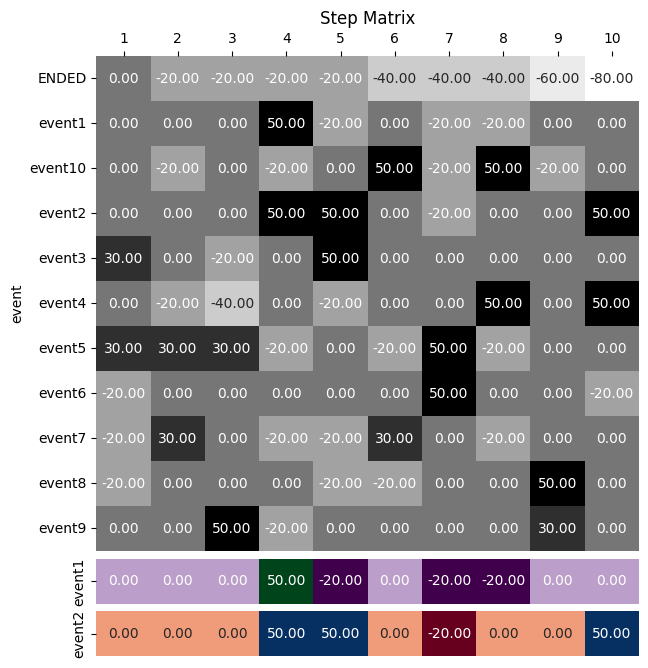

In [102]:
sm.plot_difference(all_events_users, not_all_events_users, max_steps=10, threshold=0.05, target_events=['event1', 'event2'], weight_col='user_id')

In [59]:
difference_matrix = merged_matrix.filter(like='_1').subtract(merged_matrix.filter(like='_2').values)
difference_matrix.columns = [col.replace('_1', '') for col in difference_matrix.columns]
difference_matrix

,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
ENDED,0.0,-20.0,-20.0,-20.0,-20.0,-40.0,-40.0,-40.0,-60.0,-80.0
event1,0.0,0.0,0.0,50.0,-20.0,0.0,-20.0,-20.0,0.0,0.0
event10,0.0,-20.0,0.0,-20.0,0.0,50.0,-20.0,50.0,-20.0,0.0
event2,0.0,0.0,0.0,50.0,50.0,0.0,-20.0,0.0,0.0,50.0
event3,30.0,0.0,-20.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
event4,0.0,-20.0,-40.0,0.0,-20.0,0.0,0.0,50.0,0.0,50.0
event5,30.0,30.0,30.0,-20.0,0.0,-20.0,50.0,-20.0,0.0,0.0
event6,-20.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,-20.0
event7,-20.0,30.0,0.0,-20.0,-20.0,30.0,0.0,-20.0,0.0,0.0


In [52]:
not_all_events_users

0     user1
1    user10
2    user11
3    user12
4    user13
Name: user_id, dtype: object

In [130]:

# step_cols = [i for i in range(1, max_steps + 1)]
# m.loc[:, step_cols] = m.loc[:, step_cols].divide(m.loc[:, step_cols].sum()).mul(100).round(1)
threshold: float = 0.15
normal_events = m.loc[m.max(axis=1) >= threshold * 100]
thresholded_events = m.loc[m.max(axis=1) < threshold * 100]

# Суммируем значения всех строк в thresholded_events
sum_row = thresholded_events.sum()

# Создаем новый индекс с учетом количества строк в thresholded_events
new_index = f'Thresholded_{thresholded_events.shape[0]}'

# Добавляем новую строку к normal_events
normal_events.loc[new_index] = sum_row

C:\Users\razue\AppData\Local\Temp\ipykernel_10108\3317989321.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_events.loc[new_index] = sum_row


In [131]:
normal_events

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event9,6.0,6.0,10.0,4.0,24.0,8.0,6.0,6.0,10.0,6.0
Thresholded_3,30.0,24.0,24.0,20.0,30.0,30.0,24.0,32.0,24.0,24.0


In [121]:
m

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event4,14.0,8.0,14.0,8.0,10.0,10.0,10.0,14.0,8.0,4.0
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event8,10.0,10.0,6.0,10.0,10.0,8.0,6.0,6.0,10.0,12.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event7,6.0,6.0,4.0,2.0,10.0,12.0,8.0,12.0,6.0,8.0


In [107]:
m

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event4,14.0,8.0,14.0,8.0,10.0,10.0,10.0,14.0,8.0,4.0
event2,12.0,8.0,12.0,8.0,12.0,6.0,20.0,8.0,8.0,12.0
event3,12.0,14.0,8.0,18.0,12.0,6.0,8.0,6.0,12.0,16.0
event5,12.0,10.0,6.0,12.0,8.0,8.0,22.0,14.0,18.0,10.0
event10,10.0,18.0,8.0,14.0,2.0,16.0,4.0,16.0,8.0,12.0
event1,10.0,12.0,10.0,14.0,4.0,20.0,10.0,8.0,10.0,14.0
event8,10.0,10.0,6.0,10.0,10.0,8.0,6.0,6.0,10.0,12.0
event6,8.0,8.0,22.0,10.0,8.0,6.0,6.0,10.0,10.0,6.0
event7,6.0,6.0,4.0,2.0,10.0,12.0,8.0,12.0,6.0,8.0


In [92]:
m.set_index('event')

step,1,2,3,4,5,6,7,8,9,10
event,,,,,,,,,,
event6,11.6,9.4,13.0,6.4,11.0,10.6,9.4,9.0,6.2,5.4
event3,11.0,10.2,9.0,10.8,9.2,6.2,7.8,6.0,5.8,4.8
event9,10.8,8.6,11.2,8.8,9.2,9.4,8.8,6.6,5.0,5.2
event5,10.6,9.2,9.0,11.0,10.8,7.0,8.0,6.6,7.4,5.2
event4,10.2,10.4,9.4,10.0,7.2,8.0,9.8,6.6,6.4,3.8
event2,10.0,9.0,8.2,10.2,10.6,9.2,7.0,8.4,8.0,6.6
event10,9.8,10.8,9.8,11.8,10.6,10.6,8.6,7.8,6.4,6.4
event1,8.8,10.6,11.2,9.0,8.8,8.2,7.0,8.0,6.0,7.4
event7,8.6,12.0,10.2,10.0,11.2,12.4,7.4,9.0,8.8,6.6


In [50]:
data['step'] = data.groupby('user_id')['event_datetime'].cumcount() + 1
data[data['user_id'] == 'user99']

,user_id,event,event_datetime,city,operation_system,status,step
163,user99,event3,2025-03-02 21:37:10.545635,city8,iOS,status1,1
351,user99,event9,2025-01-06 21:37:10.545635,city7,Android,status2,2
370,user99,event5,2024-11-08 21:37:10.545635,city10,Android,status2,3
393,user99,event10,2025-01-13 21:37:10.545635,city3,Android,status2,4
462,user99,event8,2024-12-27 21:37:10.545635,city3,Android,status1,5
472,user99,event9,2025-01-13 21:37:10.545635,city6,Android,status2,6
